**Video Categorization: This project addresses multi-class video classification on the UCF101 dataset using deep learning. The pipeline extracts a fixed number of frames from each video, preprocesses them, and constructs TensorFlow datasets for model training and validation. The model leverages EfficientNetB0 as a feature extractor, with the top layers partially unfrozen to enable fine-tuning for domain adaptation. Data augmentation is applied to each frame using TimeDistributed Keras layers within the model architecture, ensuring that augmentations operate on individual frames rather than the entire video tensor. This approach resolves the shape incompatibility encountered when applying augmentation in the data pipeline, and enables robust feature learning for accurate video categorization.**

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import gc
import cv2 
import glob
import time
import random
import imageio

import tensorflow as tf
from tensorflow import keras
from IPython.display import display, clear_output
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g23_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g10_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c04.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g16_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g04_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g25_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g05_c03.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g02_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g12_c03.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g11_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g07_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g06_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g05_c01.avi
/kaggle/input/ucf101

In [3]:
ucf101_root = "/kaggle/input/ucf101/UCF101/UCF-101/"

In [5]:
epochs = 9
batch_size = 29
classes = ["Archery", "Basketball", "HighJump", "Rowing", "CliffDiving"]

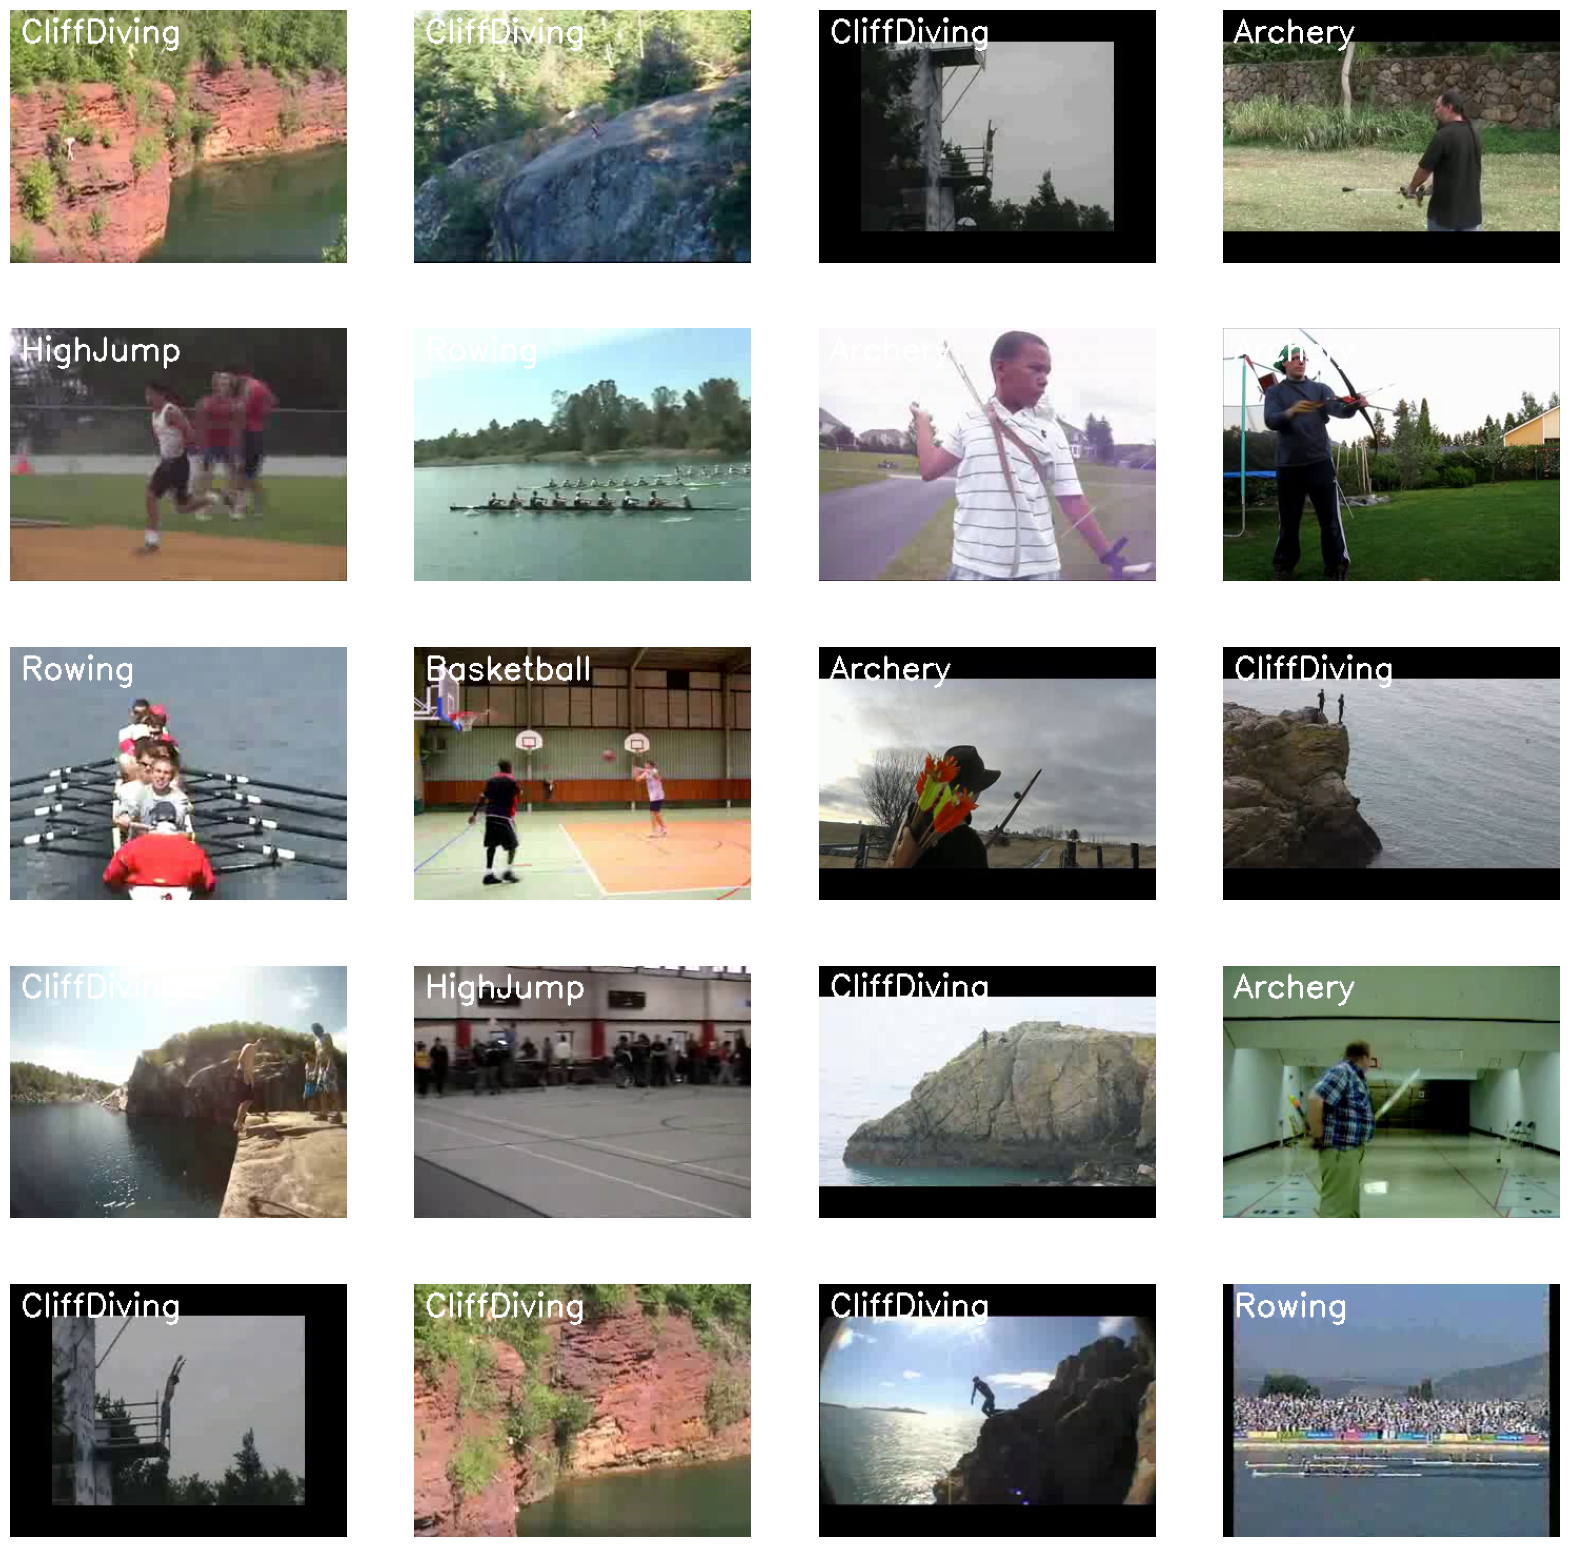

In [6]:
file_paths, targets = [], []
for i, cls in enumerate(classes):
    video_files = glob.glob(f"{ucf101_root}{cls}/*.avi")
    file_paths.extend(video_files)
    targets.extend([i] * len(video_files))

plt.figure(figsize=(20, 20))

num_videos_to_display = min(20, len(file_paths))  
random_indices = random.sample(range(len(file_paths)), num_videos_to_display)

for counter, idx in enumerate(random_indices, 1):
    video_path = file_paths[idx]
    
    class_name = os.path.basename(os.path.dirname(video_path))

    video_reader = cv2.VideoCapture(video_path)
    ret, bgr_frame = video_reader.read()
    video_reader.release()

    if ret:
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (255, 255, 255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

plt.show()

In [7]:
file_paths[0:1]

['/kaggle/input/ucf101/UCF101/UCF-101/Archery/v_Archery_g25_c05.avi']

In [8]:
def preprocess_frame(frame, size=(224, 224)):
    frame = tf.image.resize_with_pad(frame, size[0], size[1])
    return frame

def extract_frames(video_path, num_frames=9, frame_size=(224, 224), skip_frames=19):
    frames = []
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    max_start = max(0, total_frames - (num_frames - 1) * skip_frames - 1)
    start_frame = random.randint(0, max_start) if max_start > 0 else 0
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    success, frame = video.read()
    if success:
        frames.append(preprocess_frame(frame, frame_size))

        for _ in range(num_frames - 1):
            for _ in range(skip_frames):
                video.read()  
            success, frame = video.read()
            if success:
                frames.append(preprocess_frame(frame, frame_size))
            else:
                frames.append(tf.zeros_like(frames[0]))

    video.release()

    frames_array = np.array(frames)[..., ::-1]
    return frames_array

x_values = np.array([extract_frames(path, num_frames=10) for path in tqdm(file_paths)])
y_values = np.array(targets)

  0%|          | 0/677 [00:00<?, ?it/s]

I0000 00:00:1746384510.272869      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
x_values

array([[[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0.

In [8]:
x_values.shape

(677, 10, 224, 224, 3)

In [9]:
y_values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [10]:
y_values.shape

(677,)

In [9]:
train_x_values, val_x_values, train_y_values, val_y_values = train_test_split(
    x_values, y_values, test_size=0.2, random_state=39  
)

In [12]:
print("Train X shape:", train_x_values.shape)
print("Validation X shape:", val_x_values.shape)
print("Train Y shape:", train_y_values.shape)
print("Validation Y shape:", val_y_values.shape)

Train X shape: (541, 10, 224, 224, 3)
Validation X shape: (136, 10, 224, 224, 3)
Train Y shape: (541,)
Validation Y shape: (136,)


In [10]:
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_x_values, train_y_values)) 
    .shuffle(len(train_x_values))  
    .batch(batch_size) 
    .cache()  
    .prefetch(tf.data.AUTOTUNE) 
)

valid_ds = (
    tf.data.Dataset.from_tensor_slices((val_x_values, val_y_values)) 
    .batch(batch_size)  
    .cache()  
    .prefetch(tf.data.AUTOTUNE) 
)

del x_values, y_values
gc.collect() 

33773

In [12]:
from tensorflow.keras.applications.efficientnet import preprocess_input

base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 20
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

input_shape = (10, 224, 224, 3)

def preprocess(images, labels):
    images = preprocess_input(images)
    return images, labels

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

model = keras.Sequential([
    keras.layers.Input(shape=input_shape),
    keras.layers.TimeDistributed(data_augmentation),  # <--- Apply augmentation per frame
    keras.layers.TimeDistributed(base_model),
    keras.layers.GlobalAveragePooling3D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(classes))
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=valid_ds,
    callbacks=[early_stop]
)


Epoch 1/30


E0000 00:00:1746384881.704572      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/time_distributed_1_2/block2b_drop_19/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746384892.131283     179 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/19 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.4142 - loss: 1.4252 - val_accuracy: 0.6103 - val_loss: 1.0486
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 556ms/step - accuracy: 0.7633 - loss: 0.9292 - val_accuracy: 0.7353 - val_loss: 0.7823
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 556ms/step - accuracy: 0.8610 - loss: 0.6527 - val_accuracy: 0.8235 - val_loss: 0.5791
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - accuracy: 0.9247 - loss: 0.4692 - val_accuracy: 0.8603 - val_loss: 0.4299
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accuracy: 0.9459 - loss: 0.3277 - val_accuracy: 0.8897 - val_loss: 0.3592
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - accuracy: 0.9665 - loss: 0.2109 - val_accuracy: 0.9265 - val_loss: 0.2970
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - accuracy: 0.9835 - loss: 0.1482 - val_accuracy: 0.9265 - val_loss: 0.2531
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 556ms/step - accuracy: 0.9922 - loss: 0.1106 - val_accuracy: 0.9265 

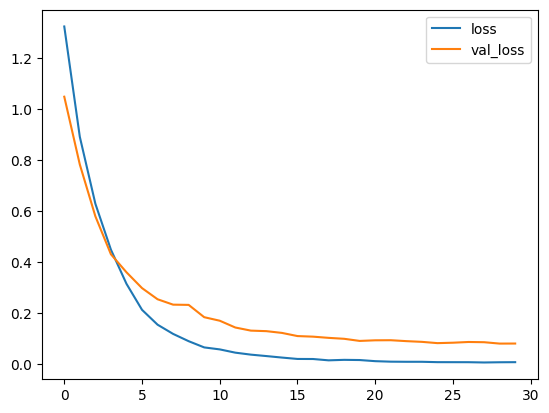

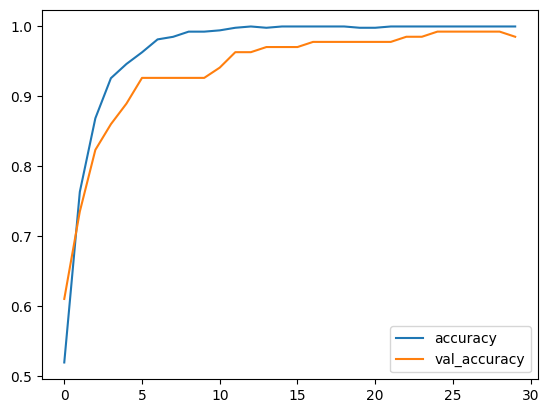

In [22]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show

In [16]:

y_true = np.concatenate([y for x, y in valid_ds], axis=0)

y_pred_logits = model.predict(valid_ds)

y_pred = np.argmax(y_pred_logits, axis=1)

class_report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", class_report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step 
Classification Report:
               precision    recall  f1-score   support

     Archery       1.00      1.00      1.00        28
  Basketball       0.97      1.00      0.98        28
    HighJump       1.00      0.95      0.98        22
      Rowing       1.00      1.00      1.00        29
 CliffDiving       1.00      1.00      1.00        29

    accuracy                           0.99       136
   macro avg       0.99      0.99      0.99       136
weighted avg       0.99      0.99      0.99       136



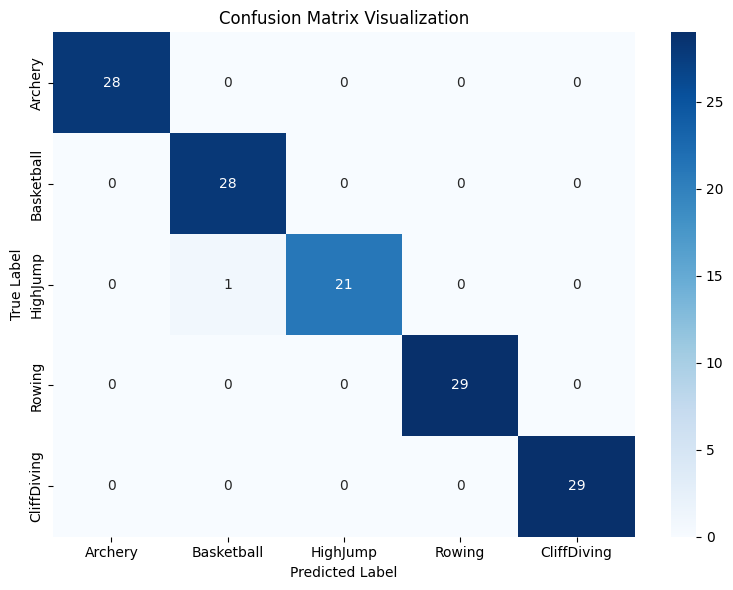

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.tight_layout()
plt.show()

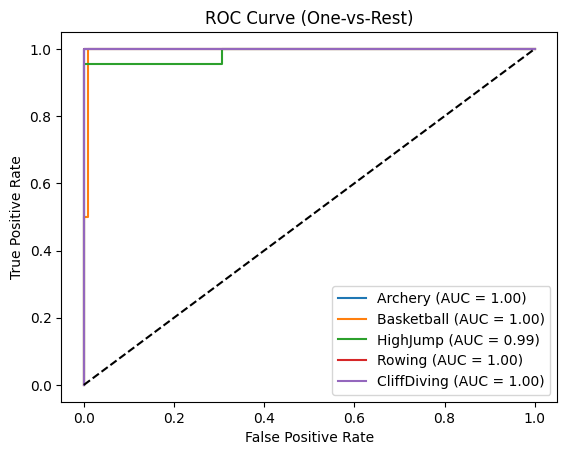

In [18]:

y_true_bin = label_binarize(y_true, classes=range(len(classes)))
y_pred_prob = tf.nn.softmax(y_pred_logits).numpy()

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

In [31]:
def detect_video(video_path, model, class_names, n_frames=10, output_size=(224, 224), frame_step=15):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    while cap.isOpened():
        frames = []
        for _ in range(n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frame_resized = cv2.resize(frame, output_size)
            frame_resized = preprocess_input(frame_resized)  
            frames.append(frame_resized)

        if len(frames) < n_frames:
            break

        frames = np.array(frames)
        frames = np.expand_dims(frames, axis=0)

        predictions = model.predict(frames)
        class_idx = np.argmax(predictions)
        confidence = np.max(tf.nn.softmax(predictions))

        # Read frame again for display
        ret, frame = cap.read()
        if not ret:
            break
                
        cv2.rectangle(frame, (10, 10), (160, 40), (0, 0, 0), -1)
        text = f"{class_names[class_idx]}: {confidence:.2f}"
        cv2.putText(frame, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        out.write(frame)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display_frame(frame_rgb)

        time.sleep(0.03)

    cap.release()
    out.release()
    print("Output: 'output.avi'.")

def display_frame(frame_rgb):
    clear_output(wait=True)
    import PIL.Image
    img = PIL.Image.fromarray(frame_rgb)
    display(img)

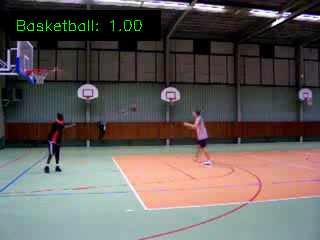

Output: 'output.avi'.


In [32]:
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/Basketball/v_Basketball_g01_c01.avi", model, classes)

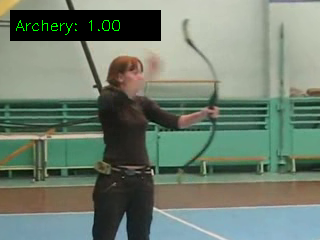

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Output: 'output.avi'.


In [33]:
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/Archery/v_Archery_g01_c02.avi", model, classes)

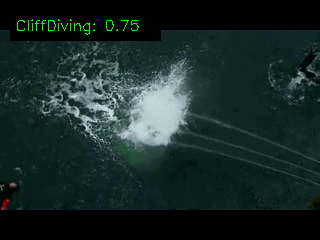

Output: 'output.avi'.


In [34]:
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/CliffDiving/v_CliffDiving_g01_c01.avi", model, classes)

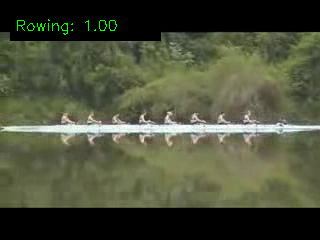

Output: 'output.avi'.


In [35]:
detect_video("/kaggle/input/ucf101/UCF101/UCF-101/Rowing/v_Rowing_g01_c03.avi", model, classes)